# Exercise 03: Lukas Kanade

In this exercise, we implement the Lucas-Kanade algorithm for estimating optical flow between two consecutive image frames. The goal is to track how points move from one image to the next using image gradients and the structure tensor as introduced in the lecture.


In [106]:
try:
    import cv2
except:
    !pip install opencv-python
    import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from scipy.signal import convolve2d as conv2

In [107]:
from exercise_code import getM, getq, getHarrisCorners, getFlow, drawPoints, getGradients, getTemporalPartialDerivative, getGaussiankernel
from tests import test_flow_absolute, test_flow_angular, test_flow_computation_time, test_flow_endpoint, test_gradients, test_getM,  test_getGaussiankernel, test_getHarrisCorners

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
# wget the optical flow dataset
import os

dataset_path = '../datasets/exercise_03'
os.makedirs(dataset_path, exist_ok=True)
if not os.path.exists(dataset_path+'/other-color-allframes.zip'):
    !wget https://vision.middlebury.edu/flow/data/comp/zip/other-color-allframes.zip --directory-prefix={dataset_path}/
    !unzip {dataset_path}/other-color-allframes.zip -d {dataset_path}/

    !wget https://vision.middlebury.edu/flow/data/comp/zip/other-gt-flow.zip --directory-prefix={dataset_path}/
    !unzip {dataset_path}/other-gt-flow.zip -d {dataset_path}/


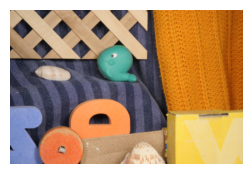

In [109]:
# Load the original image
im1 = Image.open(dataset_path+'/other-data/RubberWhale/frame10.png')
im1 = np.array(im1)

plt.figure(figsize=(3, 3))
plt.axis('off')
plt.imshow(im1)

## Part I: Structure Tensor

In order to be able to detect corners in an image and compute optical flow, the structure tensor $M$ shall be computed in this exercise.

At first compute the image gradients $I_x$ and $I_y$ using central differences.
- Go to ```getGradients``` in ```exercise_code/utils.py``` and fill in the missing lines of code.

For visual intuition on the image gradient, we provide two examples below.

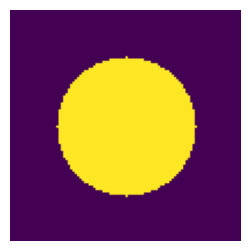

In [110]:
# We create an image of a white circle on black background to check the computet gradients
H, W = 100, 100
im1 = np.zeros((H, W), dtype=np.uint8)
center = (W // 2, H // 2)
radius = 30

Y, X = np.ogrid[:H, :W] # ex. ogrid[0:3, 0:2] -> [[0], [1], [2]] and [[0,1]]
mask = (X - center[0])**2 + (Y - center[1])**2 <= radius**2 # within the circle it's 1 (white) 
im1[mask] = 10

plt.figure(figsize=(3, 3))
plt.axis('off')
plt.imshow(im1)

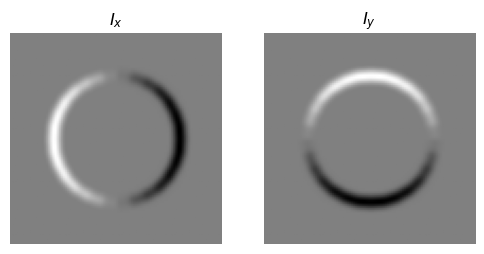

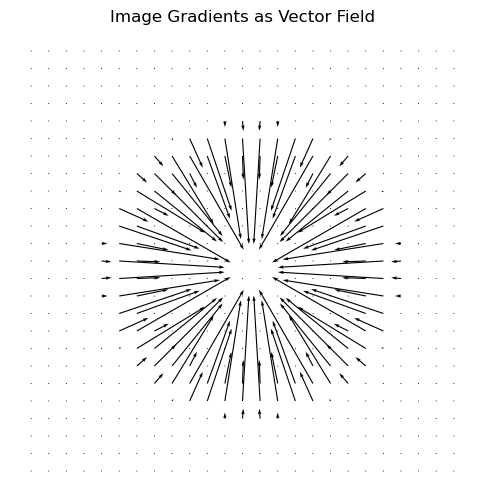

In [111]:
# get image gradients
Ix, Iy = getGradients(im1, sigma=2) #No smoothing

# show image gradients
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(Ix, cmap='gray')
plt.title('$I_x$')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(Iy, cmap='gray')
plt.title('$I_y$')
plt.axis('off')
# show image gradients by vector field
plt.figure(figsize=(6,6))
X = np.arange(0, Ix.shape[1], 1)
Y = np.arange(0, Ix.shape[0], 1)

# plot every 4th vector to avoid clutter
d = 4
q = plt.quiver(X[::d],Y[::d],Ix[::d,::d],-1*Iy[::d,::d])
plt.axis('off')
plt.title('Image Gradients as Vector Field')
ax = plt.gca()
ax.invert_yaxis()

#The gradient vector should point in the direction of largest possible intensity increase


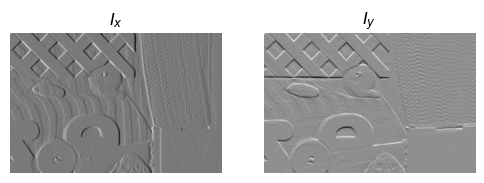

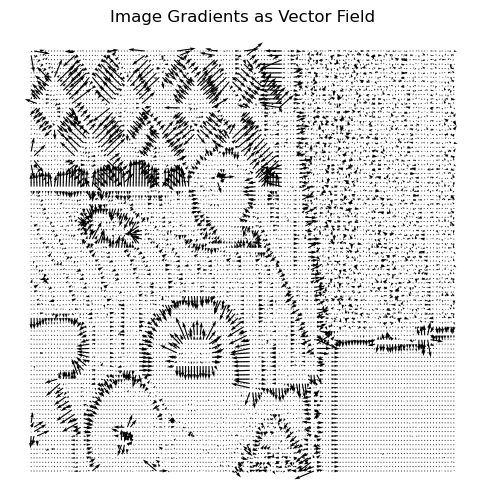

In [112]:
# Now we do the same for a real sample
im1 = Image.open(dataset_path+'/other-data/RubberWhale/frame10.png')
# convert to grayscale
im1 = im1.convert('L')
im1 = np.array(im1)

# get image gradients
Ix, Iy = getGradients(im1, sigma=1)


# show image gradients
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(Ix, cmap='gray')
plt.title('$I_x$')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(Iy, cmap='gray')
plt.title('$I_y$')
plt.axis('off')
# show image gradients by vector field
plt.figure(figsize=(6,6))
X = np.arange(0, Ix.shape[1], 1)
Y = np.arange(0, Ix.shape[0], 1)

# plot every 4th vector to avoid clutter
d = 4
q = plt.quiver(X[::d],Y[::d],Ix[::d,::d],-1*Iy[::d,::d])
plt.axis('off')
plt.title('Image Gradients as Vector Field')
ax = plt.gca()
ax.invert_yaxis()

In [113]:
test_gradients()

INFO:root:GradientZeroImage passed: Zero input yields zero gradients.
INFO:root:GradientHorizontalRamp passed: Horizontal ramp yields correct Ix and zero Iy.
INFO:root:GradientVerticalRamp passed: Vertical ramp yields correct Iy and zero Ix.
INFO:root:All tests of GradientTests passed.
Tests passed: 3/3
INFO:root:Score: 100/100


100

In order to compute the structure tensor $M$ we need a two-dimensional Gaussian Kernel as a weighting function.

- Compute  a two-dimensional Gaussian Kernel with a standard deviation. Use a kernel size (and hence integration window size) $k = 4\sigma+1$. Go to ```getGaussiankernel``` in ```exercise_code/utils.py``` and fill in the missing lines of code to compute the kernel $G$.

For visual intuition on the effect of applying the kernel to an example image through convolution, we provide an example below.

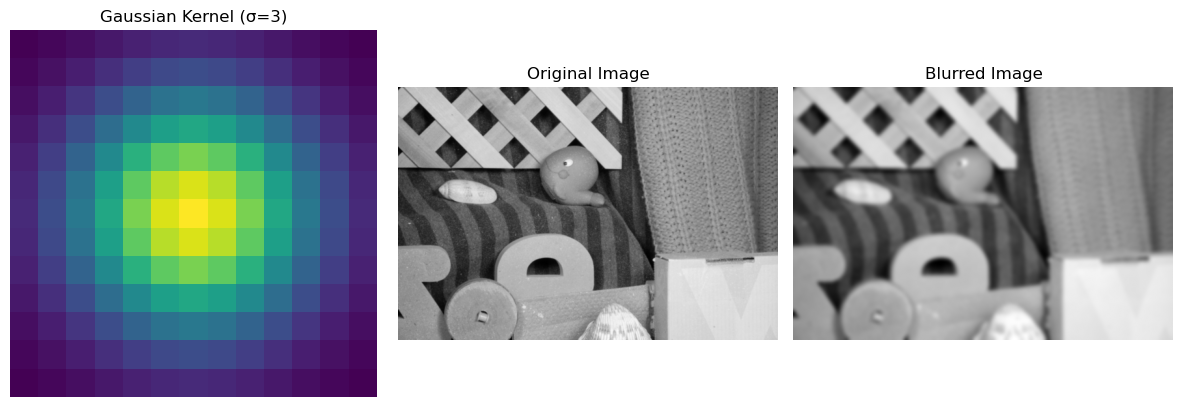

In [114]:
sigma = 3 #try different values to observe how sigma affects the smoothing/blurring effect during convolution
G = getGaussiankernel(sigma)

# gaussian blur using the computed kernel
blurred = conv2(im1, G, 'same',  boundary='symm')

plt.figure(figsize=(12, 4))

# gaussian kernel as heatmap
plt.subplot(1, 3, 1)
plt.imshow(G, cmap='viridis', interpolation='nearest')
plt.title(f'Gaussian Kernel (σ={sigma})')
plt.axis('off')

# original image
plt.subplot(1, 3, 2)
plt.imshow(im1, cmap='gray')
plt.title('Original Image')
plt.axis('off')

#blurred image
plt.subplot(1, 3, 3)
plt.imshow(blurred, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')
plt.tight_layout()
plt.show()


In [115]:
test_getGaussiankernel()

INFO:root:GaussianKernelSum passed: all kernels sum to 1.
INFO:root:GaussianKernelSymmetry passed: all kernels are symmetric.
INFO:root:GaussianKernelHardcoded passed: exact values correct for σ=0.5 and σ=1.0.
INFO:root:All tests of GaussianKernelTests passed.
Tests passed: 3/3
INFO:root:Score: 100/100


100

Now write a function that computes the entries of the structure tensor $M$ (see question 1(a) of exercise sheet 5) for every pixel $(x,y)$ of an image $I$. 

- Compute the structure tensor using a weighting function $G$ to compute the structure tensor $M$, i.e. a $2 \times 2$ matrix for each Pixel.  Why is it not necessary to compute $m_{21}$? Go to ```getM``` in ```exercise_code/utils.py```and fill in the missing lines of code.

In [116]:
# get structure tensor
M = getM(Ix, Iy, sigma=1)

In [117]:
test_getM()

INFO:root:MShapeTest passed: M has correct shape.
INFO:root:MZeroGradient passed: zero gradients yield zero structure tensor everywhere.
INFO:root:MInteriorHardcodedValuesTest passed: interior M values match expected results.
INFO:root:All tests of MTests passed.
Tests passed: 3/3
INFO:root:Score: 100/100


100

## Part II: Corner Detection

Now let us compute some intereset points which we want to track.
In this exercise you will implement the Harris corner detector. Go to ```getHarrisCorners``` in ```exercise_code/getHarrisCorners.py``` and fill in the missing lines of code using the following method:

- Compute the scoring function $C := \text{det}(M) - \kappa \text{ trace}^2(M)$ for each pixel $(x,y)$.
- Find all pixels $(x,y)$ for which $C(x,y) > \theta$, and which are a local maximum of the scoring function, i.e. all four adjacent pixel have a lower score.

In [118]:
k = 0.05 # k for Harris corner detection
t = 1e-6 # threshold for Harris corner detection

score, points = getHarrisCorners(M, k, t)

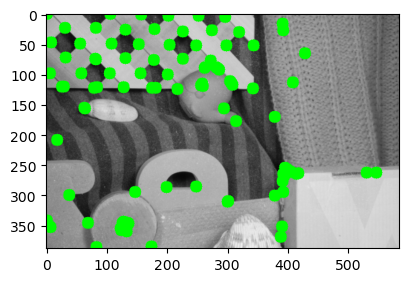

In [119]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)

im1_ = drawPoints(im1.copy(), points[:, [1, 0]].T)
plt.imshow(im1_)

In [120]:
test_getHarrisCorners()

INFO:root:HarrisCornerCenter passed: detected exactly the center corner with correct score.
INFO:root:HarrisCornerThreshold passed: no corners detected when threshold > center score.
INFO:root:HarrisCornerEdgePoints passed: detected corners at (0,0) and (4,4) with correct scores.
INFO:root:All tests of HarrisCornerTests passed.
Tests passed: 3/3
INFO:root:Score: 100/100


100

## Part III: Optical Flow

In this exercise you will implement the Lucas-Kanade method to compute optical flow.
But first check the ground truth data as a reference.

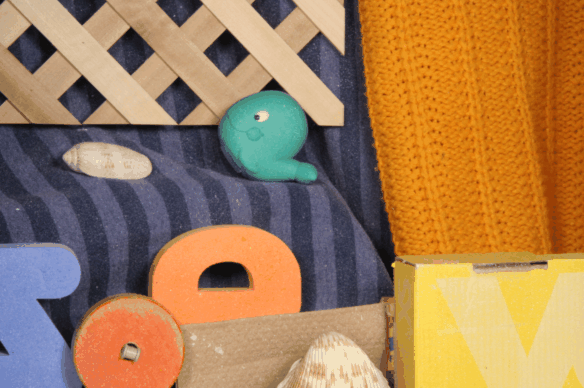

In [121]:
# save a gif of the two images
im1 = Image.open(dataset_path+'/other-data/RubberWhale/frame10.png')
im2 = Image.open(dataset_path+'/other-data/RubberWhale/frame11.png')
# overwrite the gif file

im1.save(dataset_path+'/img.gif', save_all=True, append_images=[im2], duration=1000, loop=0)
# show the gif
from IPython.display import Image as IPImage
IPImage(filename=dataset_path+'/img.gif')


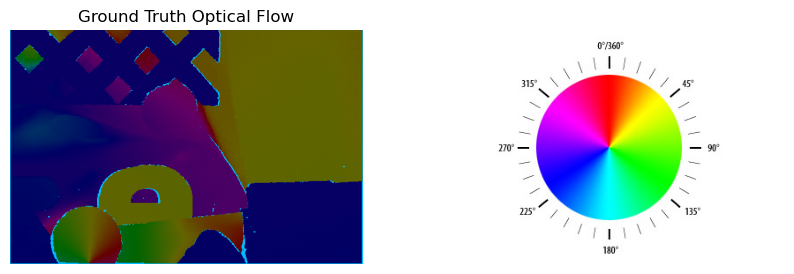

In [122]:
flow = cv2.readOpticalFlow(dataset_path+'/other-gt-flow/RubberWhale/flow10.flo')

mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
mag[mag>2357022699]=0
hsv = np.zeros_like(im1)
hsv[..., 0] = ang*180/np.pi/2
hsv[..., 1] = 255
hsv[..., 2] = 255
hsv[..., 2] = cv2.normalize(mag, None, 100, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(bgr)
plt.axis('off')
plt.title('Ground Truth Optical Flow')
plt.subplot(1, 2, 2)
# read the image
im_hsv = Image.open('hsv.jpg')
plt.axis('off')
plt.imshow(im_hsv)

In [123]:
im1_gray = im1.convert('L')
im2_gray = im2.convert('L')

im1_gray = np.array(im1_gray)
im2_gray = np.array(im2_gray)

### OpenCV Lukas Kanade Implementation

As a reference you can checkout the openCV implementation of the Lukas Kanade optical flow.
You can already see that it can capture the direction of movement quite accurately.

In [124]:
# get dense points for flow
x = np.arange(0, im1_gray.shape[0], 1)
y = np.arange(0, im1_gray.shape[1], 1)
x, y = np.meshgrid(x, y)
p0 = np.array([y.flatten(), x.flatten()]).T # opencv uses different order
p0 = p0[:,None,:].astype(np.float32)
lk_params = dict( winSize = (15, 15),
 maxLevel = 0,
 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
p1, st, err = cv2.calcOpticalFlowPyrLK(im1_gray, im2_gray, p0, None, **lk_params)

# Select good points
good_new = p1[st==1]
good_old = p0[st==1]

flow_lk = np.zeros((im1_gray.shape[0], im1_gray.shape[1], 2))
# fill in the flow
for i in range(len(good_new)):
    try:
        flow_lk[int(good_old[i][1]), int(good_old[i][0])] = good_new[i] - good_old[i] # opencv uses different order
    except:
        pass

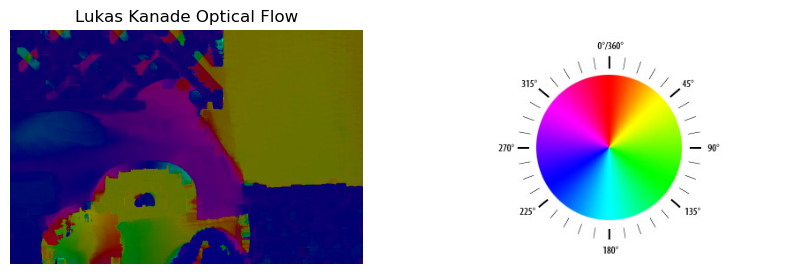

In [125]:
mag, ang = cv2.cartToPolar(flow_lk[...,0], flow_lk[...,1])
hsv = np.zeros_like(im1)
hsv[..., 0] = ang*180/np.pi/2
hsv[..., 1] = 255
hsv[..., 2] = 255
hsv[..., 2] = cv2.normalize(mag, None, 100, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(bgr)
plt.axis('off')
plt.title('Lukas Kanade Optical Flow')
plt.subplot(1, 2, 2)
# read the image
im_hsv = Image.open('hsv.jpg')
plt.axis('off')
plt.imshow(im_hsv)

### Your Lukas Kanade implementation
Now let's start with our own implementation:
- Write a function that computes the vector $I_t$ for every pixel $(x,y)$. Go to ```getTemporalPartialDerivative``` in ```exercise_code/utils.py```and fill in the missing lines of code.
- Write a function that computes the vector $\mathbf{q}$ for every pixel $(x,y)$. Go to ```getq``` in ```exercise_code/utils.py```and fill in the missing lines of code.
- Write a function that computes the local velocity $(\hat{v}_x,\hat{v}_y)$ at the input points using the formula derived in theory. Go to ```getFlow``` in ```exercise_code/getFlow.py```and fill in the missing lines of code.
- Try different values for $\sigma$. What do you observe?


In [126]:
sigma_gradient = 1
sigma = 8
It = getTemporalPartialDerivative(im1_gray, im2_gray, sigma=sigma_gradient)
Ix, Iy = getGradients(im1_gray, sigma=sigma_gradient)
q = getq(It, Ix, Iy, sigma=sigma)
print(q.shape)
M = getM(Ix, Iy, sigma=sigma)
print(M.shape)

(388, 584, 2)
(388, 584, 2, 2)


Now lets compute the flow.

In [127]:
# get dense points for flow
x = np.arange(0, im1_gray.shape[0], 1)
y = np.arange(0, im1_gray.shape[1], 1)
x, y = np.meshgrid(x, y)
points = np.array([x.flatten(), y.flatten()]).T
flow_lk,flow_lk_points = getFlow(M, q, points)

Visualize the flow

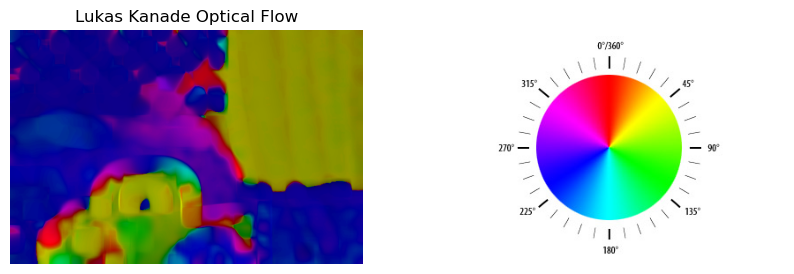

In [128]:
mag, ang = cv2.cartToPolar(flow_lk[...,0], flow_lk[...,1])
hsv = np.zeros_like(im1)
hsv[..., 0] = ang*180/np.pi/2
hsv[..., 1] = 255
hsv[..., 2] = 255
hsv[..., 2] = cv2.normalize(mag, None, 100, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(bgr)
plt.axis('off')
plt.title('Lukas Kanade Optical Flow')
plt.subplot(1, 2, 2)
# read the image
im_hsv = Image.open('hsv.jpg')
plt.axis('off')
plt.imshow(im_hsv)

## Test your method
Here, you can test your method locally. If you want to compare your method to the implementations of other students, you can submit the code on the test server.
There will be a leaderboard showing the best optical flow algorithm on the top.
For the final submission, please set the default values in your function already.
We will not pass any parameters (like $\sigma$) for evaluation.

If you want to checkout the worldwide leaderboard, you can follow this link:
[Middlebury Evaluation](https://vision.middlebury.edu/flow/eval/)


In [129]:
score = test_flow_angular(dataset_path) # cosine similarity of normalized vectors [-1,1] (the higher the better)
score = test_flow_absolute(dataset_path) # mse of vector length [0, inf] (the lower the better)
score = test_flow_computation_time(dataset_path) # time in seconds [0, inf] (the lower the better)
score = test_flow_endpoint(dataset_path) # mse of endpoint [0, inf] (the lower the better)

INFO:root:Your Lukas Kanade reached the mean cosine similarity (angular error) 0.83 on sequence RubberWhale.
Test passed
INFO:root:Your Lukas Kanade reached the mean squared error of the absolute flow 0.23 on sequence RubberWhale.
Test passed
INFO:root:Your Lukas Kanade took 1.03 s time to compute the optical flow on sequence RubberWhale.
Test passed
INFO:root:Your Lukas Kanade reached the mean endpoint error 0.52 on sequence RubberWhale.
Test passed


These are the results obtained from the opencv implementation of the highly optimized OpenCV Lukas Kanade Tracker as a reference.


![](opencv_eval.png)

In [130]:
from exercise_code.submit import submit_exercise

submit_exercise('../output/exercise03')

relevant folders: ['exercise_code']
notebooks files: ['lucas_kanade.ipynb']
Adding folder exercise_code
Adding notebook lucas_kanade.ipynb
Zipping successful! Zip is stored under: /Users/chenshien/Documents/Notes/2025 Summer (TUM)/Computer Vision II/cv2mvg/output/exercise03.zip
